In [1]:
###-----------------
### Import libraries
###-----------------

from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score  # Import function to calculate various metric

from collections.abc import Callable  # Type hinting callable objects/functions
from typing import Literal  # Literal type hints to restrict variable values

from sklearn.preprocessing import StandardScaler, LabelEncoder  # Import for standardizing features (zero mean, unit variance)

# torch import
import torch
import torch.nn as nn # for neural network
from torchsummary import summary

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

## PyTorch

Wines data

In [2]:
###----------------------
### Some basic parameters
###----------------------

RANDOM_STATE = 42 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
# torch.manual_seed(RANDOM_STATE) # setting for PyTorch as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 1000 # number of cycles to run



# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

The following line will be in our code always for Pytorch.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
data_df = pd.read_csv('Wine.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [5]:
for col in data_df.columns:
    print(f'Col: {col} - {data_df[col].unique()}')

Col: alcohol - [14.23 13.2  13.16 14.37 13.24 14.2  14.39 14.06 14.83 13.86 14.1  14.12
 13.75 14.75 14.38 13.63 14.3  13.83 14.19 13.64 12.93 13.71 12.85 13.5
 13.05 13.39 13.3  13.87 14.02 13.73 13.58 13.68 13.76 13.51 13.48 13.28
 13.07 14.22 13.56 13.41 13.88 14.21 13.9  13.94 13.82 13.77 13.74 13.29
 13.72 12.37 12.33 12.64 13.67 12.17 13.11 13.34 12.21 12.29 13.49 12.99
 11.96 11.66 13.03 11.84 12.7  12.   12.72 12.08 12.67 12.16 11.65 11.64
 12.69 11.62 12.47 11.81 12.6  12.34 11.82 12.51 12.42 12.25 12.22 11.61
 11.46 12.52 11.76 11.41 11.03 12.77 11.45 11.56 11.87 12.07 12.43 11.79
 12.04 12.86 12.88 12.81 12.53 12.84 13.36 13.52 13.62 12.87 13.32 13.08
 12.79 13.23 12.58 13.17 13.84 12.45 14.34 12.36 13.69 12.96 13.78 13.45
 12.82 13.4  12.2  14.16 13.27 14.13]
Col: malic_acid - [1.71 1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 1.48 1.73 1.81
 1.92 1.57 1.59 3.1  1.63 3.8  1.86 1.6  2.05 1.77 1.72 1.9  1.68 1.5
 1.66 1.83 1.53 1.8  1.65 3.99 3.84 1.89 3.98 4.04 3.59 2.0

Above we can see 352, 466 ... etc. These look altered

<Axes: >

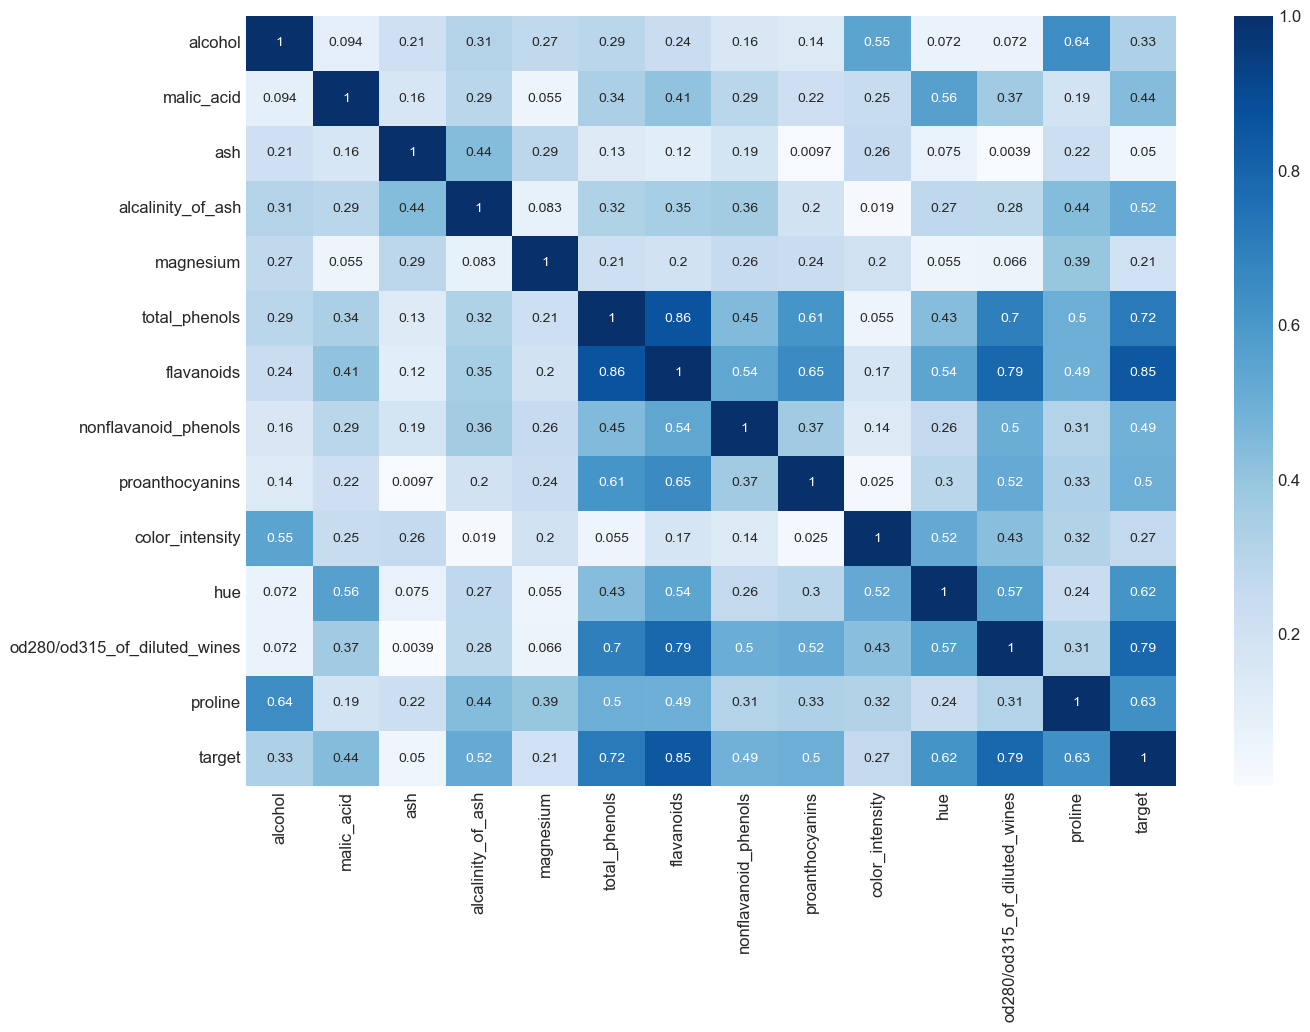

In [6]:
fig, ax = plt.subplots()
sns.heatmap(data_df.corr().abs(), ax=ax, cmap='Blues', annot=True, fmt='.2g')

In [7]:
labels = data_df[data_df.columns[-1]]
features_df = data_df.drop(data_df.columns[-1], axis=1)
features_df.shape, labels.shape 

((178, 13), (178,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels)

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
X_train.shape, X_test.shape, y_train.shape , y_test.shape

((142, 13), (36, 13), (142,), (36,))

If the target data is not in order eg 1,2,4 it skipped 3. do we should Label encode to ensure its works correctly

## Define model

In [9]:
model = nn.Sequential(
    nn.Linear(13, 8),  # specify both incoming to outgoing nodes --this connects input to hidden layer
    nn.ReLU(), # activation function sits outside the layer
    nn.Linear(8, 3) # this connects hidden layer to output layer
)

display(model) # same as print(model)

Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=3, bias=True)
)

In [46]:
# this is how we move model from cpu to gpu  -- also specify input layer (single row)
summary(model.to(device=device), (1, 13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]             112
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 3]              27
Total params: 139
Trainable params: 139
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [39]:
len(list(model.parameters()))

4

In [50]:
list(model.parameters())[0]

Parameter containing:
tensor([[ 0.4855,  0.2879,  0.3245, -0.3976,  0.0386,  0.2392,  0.1409, -0.0860,
          0.0380,  0.4920, -0.0653,  0.0185,  0.2173],
        [ 0.6305,  0.2554,  0.5088, -0.3862,  0.0693,  0.0526,  0.3371, -0.0736,
         -0.0981,  0.1721, -0.2539,  0.6253,  0.6530],
        [ 0.1201,  0.6706, -0.2510, -0.0191, -0.4328,  0.0060, -0.0447,  0.0098,
          0.2702, -0.4289, -0.1025,  0.1515, -0.0679],
        [ 0.4056,  0.2263,  0.7022,  0.4564,  0.3248, -0.4910, -0.7088, -0.1607,
         -0.5887,  0.5886, -0.4295, -0.5730,  0.5006],
        [ 0.4191,  0.2020,  0.3558, -0.9088,  0.2169,  0.1703,  0.6986, -0.2578,
         -0.3045,  0.4576, -0.0742,  0.5523,  0.3875],
        [-0.5071,  0.2623,  0.0986,  0.5780, -0.3950, -0.1818, -0.5552,  0.2570,
         -0.0625,  0.1218, -0.5020, -0.3545, -0.2916],
        [ 0.0391, -0.3548,  0.5404,  0.0259,  0.5098, -0.1480,  0.2368, -0.1384,
          0.1089, -0.3516,  0.5501,  0.1788,  0.4877],
        [-0.6996, -0.4592,

In [ ]:
list(model.parameters())[0].shape

torch.Size([8, 13])

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)

Training data is still on numpy, we need to convert it to tensor

In [12]:
train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
test_X = torch.tensor(X_test, dtype=torch.float32, device=device)

# X values can be in float but y values (labels) need to be in int64 --- only for classification

train_y = torch.tensor(y_train, dtype=torch.int64, device=device)  
test_y = torch.tensor(y_test, dtype=torch.int64, device=device)

Unit test

In [13]:
pred = model(train_X[:1])
pred

tensor([[0.2929, 0.1852, 0.0953]], grad_fn=<AddmmBackward0>)

In [14]:
loss_fn(pred, train_y[:1])

tensor(1.0001, grad_fn=<NllLossBackward0>)

In [15]:
loss_fn(pred, train_y[:1]).item()  # bring to cpu

1.000093936920166

In [ ]:
train_loss, test_loss = [], [] # to track losses
train_accuracy, test_accuracy = [], [] # to track accuracy

for epoch in range(EPOCHS):
    # ---- forward propagation starts -----
    # training mode
    model.train()
    outputs = model(train_X)
    loss = loss_fn(outputs, train_y)
    # ---- forward propagation ends-----

    # make all the gradients 0 for this step, done to avoid accumulation from previous steps, useful in dropout
    optimizer.zero_grad() 
    # ---- back propagation starts -----
    # propagate to compute the gradients  
    loss.backward()
    # take step to update the model parameters
    optimizer.step()
    # ---- back propagation ends -----

    train_loss.append(loss.item())  # train loss

    _, y_pred = torch.max(outputs, 1)  # along axis 1, returns max value

    acc = accuracy_score(y_train, y_pred.data.cpu()) # train accuracy
    train_accuracy.append(acc)

    # calculating loss for test data
    with torch.no_grad(): # stop gradient descent for some time
        model.eval() # model in eval mode -- switches off helping layers
        outputs = model(test_X)
        tst_loss = loss_fn(outputs, test_y)
        test_loss.append(tst_loss.item())
        _, y_pred = torch.max(outputs, 1)  # along axis 1, returns max value, index and we only want index

        tst_acc = accuracy_score(y_test, y_pred.data.cpu()) # est accuracy
        test_accuracy.append(tst_acc)


    if epoch %10 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item():.4f} Test Loss = {tst_loss.item():.4f}')

Epoch 0: Loss = 1.1332 Test Loss = 1.1601
Epoch 10: Loss = 1.0858 Test Loss = 1.1045
Epoch 20: Loss = 1.0390 Test Loss = 1.0506
Epoch 30: Loss = 0.9932 Test Loss = 0.9974
Epoch 40: Loss = 0.9474 Test Loss = 0.9443
Epoch 50: Loss = 0.9008 Test Loss = 0.8912
Epoch 60: Loss = 0.8534 Test Loss = 0.8381
Epoch 70: Loss = 0.8062 Test Loss = 0.7866
Epoch 80: Loss = 0.7601 Test Loss = 0.7371
Epoch 90: Loss = 0.7151 Test Loss = 0.6903
Epoch 100: Loss = 0.6719 Test Loss = 0.6466
Epoch 110: Loss = 0.6305 Test Loss = 0.6063
Epoch 120: Loss = 0.5913 Test Loss = 0.5691
Epoch 130: Loss = 0.5539 Test Loss = 0.5348
Epoch 140: Loss = 0.5182 Test Loss = 0.5030
Epoch 150: Loss = 0.4842 Test Loss = 0.4735
Epoch 160: Loss = 0.4519 Test Loss = 0.4459
Epoch 170: Loss = 0.4214 Test Loss = 0.4197
Epoch 180: Loss = 0.3925 Test Loss = 0.3951
Epoch 190: Loss = 0.3654 Test Loss = 0.3723
Epoch 200: Loss = 0.3399 Test Loss = 0.3514
Epoch 210: Loss = 0.3160 Test Loss = 0.3321
Epoch 220: Loss = 0.2939 Test Loss = 0.3142

We see that for same number of epochs (100), tensorflow loss was much lesser than pytorch loss. This is because tensorflow automatically creates mini batches and does the gradient descent on all batches. For 100, it created 5 batches, so in 100 epochs, it did gradient descent 5 * 100 = 500 times.
But we did not use batch size with torch, so in 100 epochs, it only did 100 updates as compared to 500 updates of tensorflow.

### Evaluation

In [17]:
model.eval()  # set model to evaluation mode - training off

with torch.no_grad():
    train_pred = model(train_X)
    test_pred = model(test_X)

type(train_pred), type(test_pred)

(torch.Tensor, torch.Tensor)

In [18]:
train_pred # currently it is tensor, and on device, so bring to cpu and argmax to get output

tensor([[ 5.9552, -1.2851, -1.9230],
        [ 5.5440, -0.1291, -1.9951],
        [ 6.4333, -2.3373, -2.2599],
        [ 5.9802, -1.8996, -2.2234],
        [-1.5855, -0.1561,  5.5290],
        [-2.0388,  0.5033,  6.1512],
        [-0.2987,  5.0669, -4.2440],
        [-1.1815, -1.6006,  6.1931],
        [ 7.8531, -2.5311, -1.9868],
        [ 6.2031, -3.0367, -2.3298],
        [-3.1758,  5.2318, -3.2141],
        [-3.4839,  4.7543, -3.4793],
        [ 8.6680, -4.5114, -3.0157],
        [ 4.0034, -0.3650, -2.1057],
        [-1.7310,  0.2395,  4.4491],
        [-2.8995,  4.3565, -2.2597],
        [-3.0186,  4.6637, -2.8004],
        [-0.5302,  3.5308, -3.5172],
        [ 4.1965,  0.4021, -2.4747],
        [ 3.0016, -0.0564, -2.0050],
        [ 0.0391,  3.0058, -2.8347],
        [-2.5358,  0.9298,  7.4566],
        [ 7.9475, -3.5133, -2.8667],
        [-0.3724, -1.7640,  5.2312],
        [ 0.2410, -2.0691,  4.2966],
        [ 6.0514, -1.3151, -2.2321],
        [ 5.1041, -2.4563, -2.1871],
 

In [ ]:
y_train_pred = train_pred.detach().cpu().numpy()
y_test_pred = test_pred.detach().cpu().numpy()
s

type(y_train_pred), type(y_test_pred)

""" detach() removes tensor from computation graph, 
    cpu() brings to cpu,
    numpy() to convert to numpy """;

In [20]:
y_train_pred = y_train_pred.argmax(axis=1)
y_train_pred

array([0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2,
       0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 0, 0, 1,
       2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 0, 2, 2])

In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



In [22]:
y_test_pred = y_test_pred.argmax(axis=1)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.93      0.93      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



In [32]:
hist_df = pd.DataFrame({'epochs':range(EPOCHS),
                        'loss':train_loss, 
                        'test_loss':test_loss, 
                        'acc':train_accuracy, 
                        'test_acc':test_accuracy} )

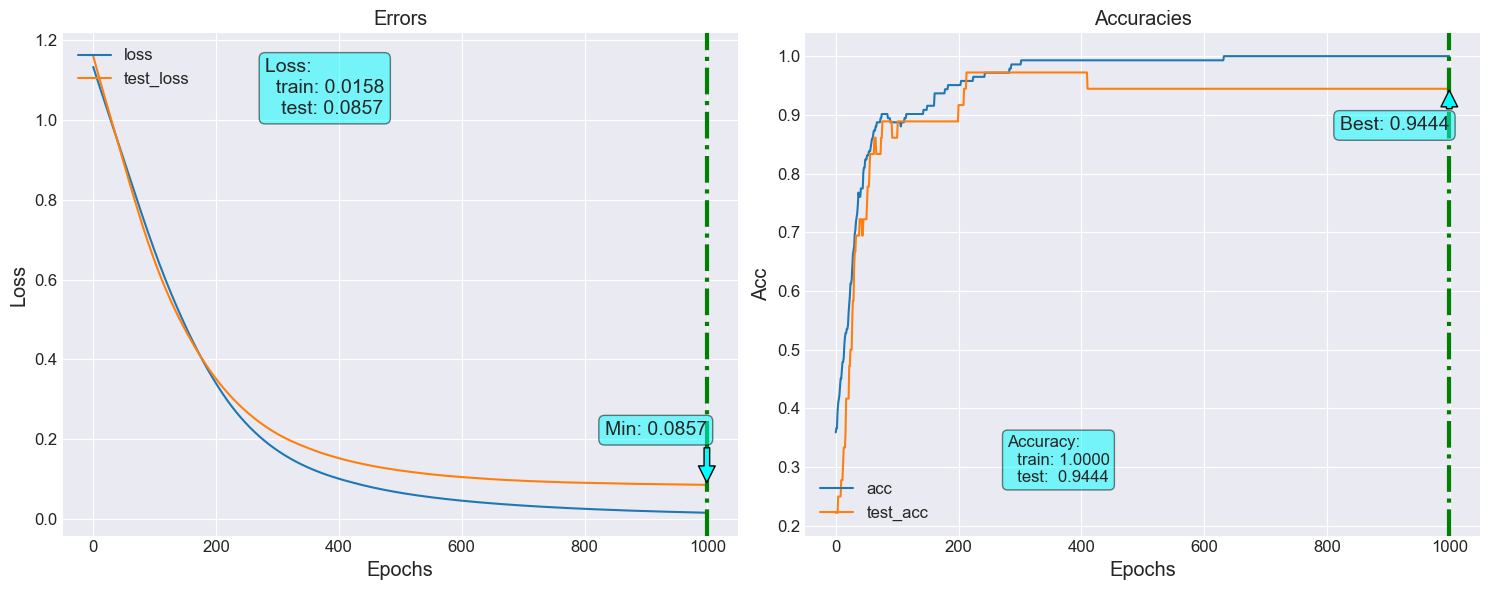

In [44]:
fn_plot_torch_hist(hist_df)

In [34]:
class_names = {}
for i, cl in enumerate(le.classes_):
    class_names[i] = cl

class_names

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

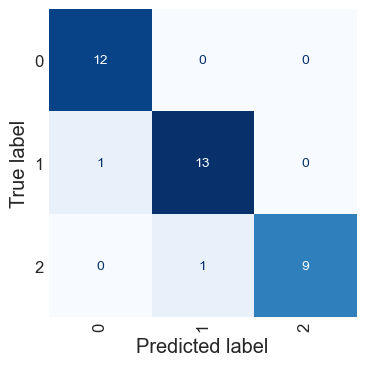

In [37]:
fn_plot_confusion_matrix(y_test, y_pred, labels=class_names)